In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

In [2]:
cam_diam = 0.1148
W = np.pi* cam_diam /2
lam = 1.54*10**-10 

cop_A = 3.597*10**-10
alum_A = 4.046*10**-10

# Open Up the Data Frames

In [3]:
df_copnofilt = pd.read_csv('cop_no_filt_temp.csv')
df_alumfilt = pd.read_csv('alum_filt_temp.csv')
df_alumnofilt = pd.read_csv('alum_no_filt_temp.csv')
df_goldnofilt = pd.read_csv('gold_no_filt_temp.csv')

#Convert all to SI
df_copnofilt['Ring']=df_copnofilt['Ring'].apply(lambda x:ufloat(x/100, 1/1000))
df_alumfilt['Ring']=df_alumfilt['Ring'].apply(lambda x:ufloat(x/100, 1/1000))
df_alumnofilt['Ring']=df_alumnofilt['Ring'].apply(lambda x:ufloat(x/100, 1/1000))
df_goldnofilt['Ring']=df_goldnofilt['Ring'].apply(lambda x:ufloat(x/100, 1/1000))

## Find the Scattering Angles for Each

In [4]:
def get_angles(df):
    df['Angle'] = np.pi * df['Ring'] / (4 * W)
    # Back rings are actually pi-angle measured
    df['Angle'] = np.where(df['Ring Type'] == 'F', df['Angle'], np.pi/2-df['Angle'])
    return df

In [5]:
df_copnofilt = get_angles(df_copnofilt)
df_alumfilt = get_angles(df_alumfilt)
df_alumnofilt = get_angles(df_alumnofilt)
df_goldnofilt = get_angles(df_goldnofilt)

## Finding Lattice Spacing

We know that

$$\frac{4 \sin^2 \theta_n}{\lambda^2} = a^{-2}(h^2+k^2+l^2)n^2 $$

It follows that

$$A \sin^2(\theta_n) = (h^2+k^2+l^2)n^2 $$

meaning that we should get a bunch of integer values for a given value of $A$. Note that

$$A= \left( \frac{2a}{\lambda} \right)^2 $$

In [6]:
def get_space_fac(df):
    df['Factor'] = df['Angle'].apply(lambda x:sin(x)**2)
    return df

In [7]:
df_copnofilt = get_space_fac(df_copnofilt)
df_alumfilt = get_space_fac(df_alumfilt)
df_alumnofilt = get_space_fac(df_alumnofilt)
df_goldnofilt = get_space_fac(df_goldnofilt)

Make sure the DataFrames are sorted in increasing order of $\sin^2 \theta$.

In [8]:
df_copnofilt = df_copnofilt.sort_values(by=['Factor']).reset_index(drop=True)
df_alumfilt = df_alumfilt.sort_values(by=['Factor']).reset_index(drop=True)
df_alumnofilt = df_alumnofilt.sort_values(by=['Factor']).reset_index(drop=True)
df_goldnofilt = df_goldnofilt.sort_values(by=['Factor']).reset_index(drop=True)

# Get Trial Points

Here we get all possible values of $n^2(h^2+k^2+l^2)$ for the "Face centered Cubic Lattice." We plot the value of $n^2(h^2+k^2+l^2)$ vs its degeneracy (certain values of $n^2(h^2+k^2+l^2)$ can be obtained through different combinations of $n$, $h$, $k$, and $l$; this corresponds to thicker rings at these locations).

In [9]:
trial_pnts_1 = np.array([((2*h+1)**2+(2*k+1)**2+(2*l+1)**2)*n**2
              for n in range(1,5) for h in range(6) for k in range(6) for l in range(6)])
nhkl_1 = np.array([str(n)+'_'+str(2*h+1)+'_'+str(2*k+1)+'_'+str(2*l+1)
              for n in range(1,5) for h in range(6) for k in range(6) for l in range(6)])

trial_pnts_2 = np.array([((2*h)**2+(2*k)**2+(2*l)**2)*n**2
              for n in range(1,5) for h in range(6) for k in range(6) for l in range(6)])
nhkl_2 = np.array([str(n)+'_'+str(2*h)+'_'+str(2*k)+'_'+str(2*l)
              for n in range(1,5) for h in range(6) for k in range(6) for l in range(6)])

trial_pnts_rep = np.concatenate((trial_pnts_1, trial_pnts_2))
nhkl_rep = np.concatenate((nhkl_1, nhkl_2))

trial_pnts = np.array(sorted(np.unique(trial_pnts_rep)))
ring_strength = np.array([(trial_pnts_rep == i).sum() for i in trial_pnts])

yeet_df = pd.DataFrame({'x':trial_pnts_rep, 'y':nhkl_rep})
yeet_df = yeet_df.sort_values(by=['x'])
yeet_df.to_csv('out.csv')

# Finding the Integers

Lets start with the filtered aluminum which should give clear lattice lines. We know that the X-Rays emitted by the X-Ray used are $0.154$nm and that the approximate lattice parameter for aluminum is $a \approx 0.4$nm. Lets then choose a variety of values for $A$ (equation above) that correspond to the range

$$a = 0.4\text{nm} \implies  A \approx 26.9$$

up to 

$$a = 0.41\text{nm} \implies  A \approx 42.17$$

In [10]:
def scale_goodness(df, trial_pnts, scale):
    non_ufloat = df['Factor'].apply(lambda x:x.nominal_value)
    raw_arr = np.array(scale*non_ufloat)
    good_param = 0
    for r in raw_arr:
        index = (np.abs(trial_pnts-r)).argmin()
        good_param += (np.abs(trial_pnts[index]-r))
    return good_param

Create arrays of scale values of $A$ to test out.

### Aluminum No Filter

In [11]:
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9
A1 = (2*a1/lam)**2; A2 = (2*a2/lam)**2

dd_al_nf = np.linspace(A1, A2, 1000)
pp_al_nf = np.array([scale_goodness(df_alumnofilt, trial_pnts, d) for d in dd_al_nf])

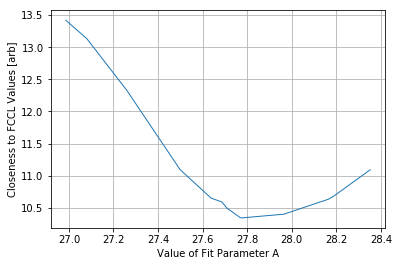

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(dd_al_nf, pp_al_nf, lw=1)
ax.grid()

ax.set_xlabel('Value of Fit Parameter A')
ax.set_ylabel('Closeness to FCCL Values [arb]')

plt.show()

### Aluminum With Filter

In [13]:
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9
A1 = (2*a1/lam)**2; A2 = (2*a2/lam)**2

dd_al_f = np.linspace(A1, A2, 1000)
pp_al_f = np.array([scale_goodness(df_alumfilt, trial_pnts, d) for d in dd_al_f])

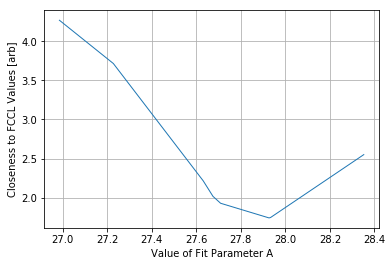

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(dd_al_f, pp_al_f, lw=1)
ax.grid()

ax.set_xlabel('Value of Fit Parameter A')
ax.set_ylabel('Closeness to FCCL Values [arb]')

plt.show()

In [15]:
aaa = 0.4046 * 10**-9
AAA = (2*aaa/lam)**2
df_alumfilt['Factor']*AAA

0     2.84+/-0.07
1     3.78+/-0.08
2     7.62+/-0.11
3    10.55+/-0.12
4    11.49+/-0.12
5    18.78+/-0.11
6    19.77+/-0.11
7    23.91+/-0.08
8    26.94+/-0.04
Name: Factor, dtype: object

### Copper No Filter

In [16]:
a1 = 0.35 * 10**-9; a2 = 0.375 * 10**-9
A1 = (2*a1/lam)**2; A2 = (2*a2/lam)**2

dd_cu_nf = np.linspace(A1, A2, 1000)
pp_cu_nf = np.array([scale_goodness(df_copnofilt, trial_pnts, d) for d in dd_cu_nf])

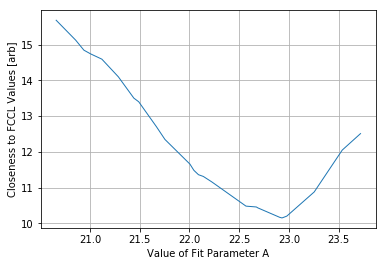

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(dd_cu_nf, pp_cu_nf, lw=1)
ax.grid()

ax.set_xlabel('Value of Fit Parameter A')
ax.set_ylabel('Closeness to FCCL Values [arb]')

plt.show()

### Gold No Filter

In [18]:
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9
A1 = (2*a1/lam)**2; A2 = (2*a2/lam)**2

dd_au_nf = np.linspace(A1, A2, 1000)
pp_au_nf = np.array([scale_goodness(df_goldnofilt, trial_pnts, d) for d in dd_au_nf])

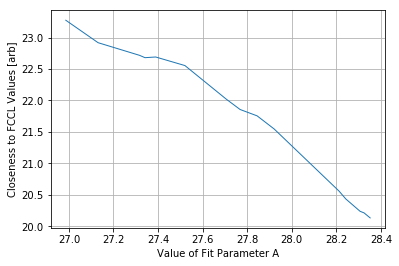

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(dd_au_nf, pp_au_nf, lw=1)
ax.grid()

ax.set_xlabel('Value of Fit Parameter A')
ax.set_ylabel('Closeness to FCCL Values [arb]')

plt.show()

## Now Get Optimal Values Using the Minima of The Plots Above

In [20]:
alum_nf_FCCL_vals = np.array(dd_al_nf[np.argmin(pp_al_nf)] * df_alumnofilt['Factor'])
alum_f_FCCL_vals = np.array(dd_al_f[np.argmin(pp_al_f)] * df_alumfilt['Factor'])
cop_nf_FCCL_vals = np.array(dd_cu_nf[np.argmin(pp_cu_nf)] * df_copnofilt['Factor'])
gold_nf_FCCL_vals = np.array(dd_au_nf[np.argmin(pp_au_nf)] * df_goldnofilt['Factor'])

alum_nf_linethickness = np.array(df_alumnofilt['Thickness'])
alum_f_linethickness = np.array(df_alumfilt['Thickness'])
cop_nf_linethickness = np.array(df_copnofilt['Thickness'])
gold_nf_linethickness = np.array(df_goldnofilt['Thickness'])

# Plot Experimental Data Vs. FCCL Values

Heres a function that removes unwanted lines for the non-filtered sources and obtains a new best fit parameter for A:

In [21]:
def remove_unwanted_lines(df, unwanted_lines, a1, a2):
    df_f = df.drop(unwanted_lines, axis=0)
    A1 = (2*a1/lam)**2; A2 = (2*a2/lam)**2
    
    dd = np.linspace(A1, A2, 1000)
    pp = np.array([scale_goodness(df_f, trial_pnts, d) for d in dd])
    
    A_ideal = np.array(dd[np.argmin(pp)])
    a_ideal = lam*np.sqrt(A_ideal)/2
    
    return np.array(A_ideal * df_f['Factor']), np.array(df_f['Thickness']), a_ideal

This function is used to make plots.

In [22]:
def plot_measured_values(ax, arr, line_thickness):
    first_time = True
    for (a, lt) in zip(arr, line_thickness):
        a_mid = a.nominal_value
        a_low = a.nominal_value - a.std_dev
        a_high = a.nominal_value + a.std_dev
        
        if first_time:
            ax.axvline(a_mid, linestyle='--', color='k', label='Experimental Value', lw=lt)
            ax.axvspan(a_low, a_high, color='r', alpha=0.2, label='Experimental Uncertainty')
            first_time = False
        else: 
            ax.axvline(a_mid, linestyle='--', color='k', lw=lt)
            ax.axvspan(a_low, a_high, color='r', alpha=0.2)
            
    return 0

Plot:

## Aluminum No Filter

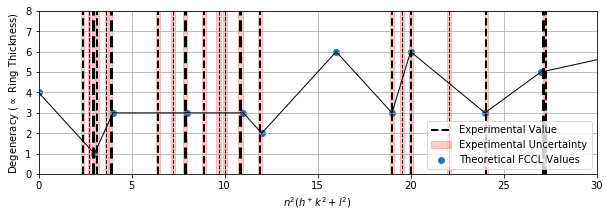

In [23]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy ($\propto$ Ring Thickness)')

plot_measured_values(ax, alum_nf_FCCL_vals, alum_nf_linethickness)

ax.grid()
ax.legend()

plt.show()

We will need to remove the unwanted lines by examining this plot.

In [24]:
unwanted_lines = [0, 1, 3, 4, 6, 7, 9, 10, 11, 15, 17, 20]
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9

(alum_nf_FCCL_vals_f,
alum_nf_linethickness_f, 
alum_nf_latticeconstant) = remove_unwanted_lines(df_alumnofilt, unwanted_lines, a1 , a2)

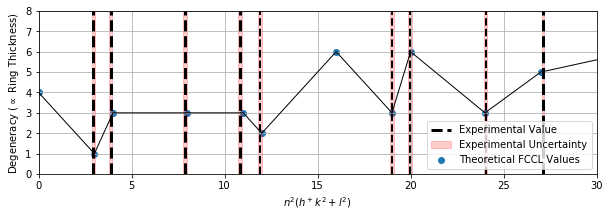

In [25]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy ($\propto$ Ring Thickness)')

plot_measured_values(ax, alum_nf_FCCL_vals_f, alum_nf_linethickness_f)

ax.grid()
ax.legend()

plt.show()

## Aluminum With Filter

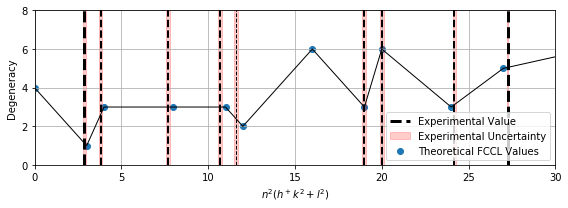

In [49]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, alum_f_FCCL_vals, alum_f_linethickness)

ax.grid()
ax.legend()

fig.tight_layout()
plt.savefig('plots/alum_filt.png', dpi=300)
plt.show()

No need to remove the unwanted lines because the nickel already did that for us. The function still provides a ice way of us getting the lattice constant though:

In [28]:
unwanted_lines = []
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9

(alum_f_FCCL_vals_f,
alum_f_linethickness_f, 
alum_f_latticeconstant) = remove_unwanted_lines(df_alumfilt, unwanted_lines, a1 , a2)

In [29]:
alum_f_FCCL_vals

array([2.8754028591786818+/-0.07393055990434504,
       3.821476075403827+/-0.08360471091184693,
       7.707845499317126+/-0.10874383634297184,
       10.670827512339544+/-0.11820277997921298,
       11.623676115248701+/-0.11991296253906623,
       18.995971085193126+/-0.11345830990148073,
       20.000592820467347+/-0.1096766097655578,
       24.188607095171534+/-0.08283199682168513,
       27.24590442228146+/-0.037520574999715194], dtype=object)

## Copper No Filter

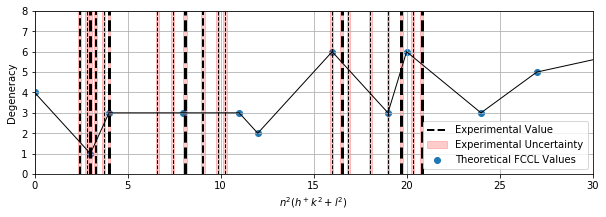

In [30]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, cop_nf_FCCL_vals, cop_nf_linethickness)

ax.grid()
ax.legend()

plt.show()

We will need to remove the unwanted lines by examining this plot.

In [31]:
unwanted_lines = [0, 1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 18, 19]
a1 = 0.35 * 10**-9; a2 = 0.375 * 10**-9

(cop_nf_FCCL_vals_f,
 cop_nf_linethickness_f,
cop_nf_latticeconstant)= remove_unwanted_lines(df_copnofilt, unwanted_lines, a1 , a2)

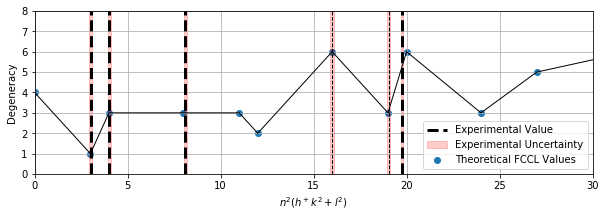

In [32]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, cop_nf_FCCL_vals_f, cop_nf_linethickness_f)

ax.grid()
ax.legend()

plt.show()

## Gold No Filter

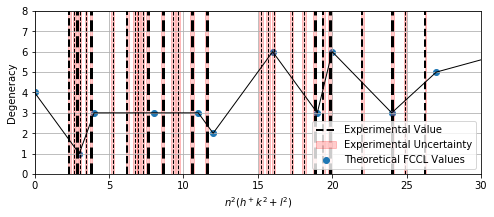

In [33]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, gold_nf_FCCL_vals, gold_nf_linethickness)

ax.grid()
ax.legend()

plt.show()

In [34]:
unwanted_lines = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 25, 27, 28]
a1 = 0.4 * 10**-9; a2 = 0.41 * 10**-9
(gold_nf_FCCL_vals_f,
gold_nf_linethickness_f,
gold_nf_latticeconstant)= remove_unwanted_lines(df_goldnofilt, unwanted_lines, a1 , a2)

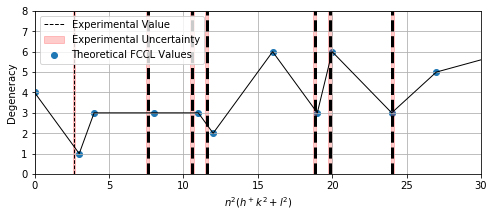

In [35]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, gold_nf_FCCL_vals_f, gold_nf_linethickness_f)

ax.grid()
ax.legend()

plt.show()

### Does the Gold Contain Copper?

In [36]:
A_goldcop = (2*cop_nf_latticeconstant/lam)**2
gold_cop_nf_FCCL_vals = np.array(A_goldcop * df_goldnofilt['Factor'])

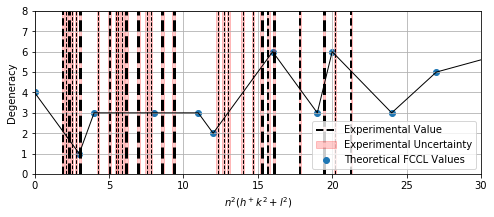

In [37]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, gold_cop_nf_FCCL_vals, gold_nf_linethickness)

ax.grid()
ax.legend()

plt.show()

In [38]:
unwanted_lines = [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 28]
a1 = 0.35 * 10**-9; a2 = 0.375 * 10**-9

(goldcop_nf_FCCL_vals_f,
goldcop_nf_linethickness_f,
goldcop_nf_latticeconstant) = remove_unwanted_lines(df_goldnofilt, unwanted_lines, a1 , a2)

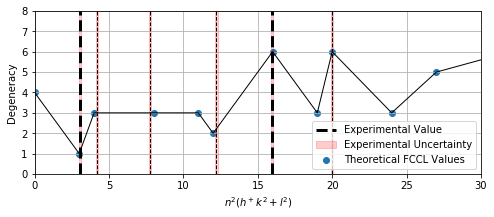

In [39]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(trial_pnts, ring_strength, lw=1, c='k')
ax.scatter(trial_pnts, ring_strength, label='Theoretical FCCL Values')
ax.set_xlim(0,30)
ax.set_ylim(0,8)

ax.set_xlabel(r'$n^2(h^+k^2+l^2)$')
ax.set_ylabel(r'Degeneracy')

plot_measured_values(ax, goldcop_nf_FCCL_vals_f, goldcop_nf_linethickness_f)

ax.grid()
ax.legend()

plt.show()

# Determining Lattice Parameter a

These lines, of course, can each be shifted to their corresponding theoretical FCCL (blue dot value) on the previous plot. This requires slight modifcications to $A=(2a/\lambda)^2$ for each line, so we will get different $A$ values for each line and thus different $A$ values for each line.

$$A\sin^2 \theta = h^2+k^2+l^2$$

$$\implies \frac{A_{exact} \sin^2 \theta}{A_{old} \sin^2 \theta} = \frac{(h^2+k^2+l^2)_{exact}}{(h^2+k^2+l^2)_{old}} $$

Now using $A_{exact}/A_{old}={a_{exact}}^2/{a_{old}}^2$ we get

$$\implies \boxed{a_{exact} = a_{old} \sqrt{\frac{(h^2+k^2+l^2)_{exact}}{(h^2+k^2+l^2)_{old}}}}$$

where $a_{old}$ is the old fitting parameter used to get all the lines in approximately the correct place, $(h^2+k^2+l^2)_{old}$ is the non-integer value of the dotted lines seen on the plots above, and $(h^2+k^2+l^2)_{exact}$ is the true integer value (blue dots).

We will obtain different values of $a_{exact}$ for each dotted line and thus many different values of the lattice parameter $a$ which we can then use to get an approximate value.

In [40]:
def get_lparams(exp_data, theo_data, a_old):
    a_exacts = np.empty(shape=len(exp_data), dtype=object)
    for i, hkl_old in enumerate(exp_data):
        hkl_exact = theo_data[np.argmin(np.abs(np.array(theo_data)-hkl_old.nominal_value))]
        a_exacts[i] = a_old * sqrt(hkl_exact/hkl_old)
    return a_exacts

In [41]:
copper_nofilter_lattice_params = get_lparams(cop_nf_FCCL_vals_f, trial_pnts, cop_nf_latticeconstant)
aluminum_nofilter_lattice_params = get_lparams(alum_nf_FCCL_vals_f, trial_pnts, alum_nf_latticeconstant)
aluminum_filter_lattice_params = get_lparams(alum_f_FCCL_vals, trial_pnts, alum_f_latticeconstant)
gold_nofilter_lattice_params = get_lparams(gold_nf_FCCL_vals_f, trial_pnts, gold_nf_latticeconstant)

In [42]:
copper_nofilter_lattice_params* 10**10

array([3.68612775874019+/-0.04136668573149004,
       3.6846747848764876+/-0.03488324771170587,
       3.667142730948783+/-0.021637048007369365,
       3.690959809702877+/-0.010615688226048239,
       3.6871525889190004+/-0.0073034678645439504,
       3.712937635789997+/-0.0065205309810815425], dtype=object)

In [43]:
gold_nofilter_lattice_params

array([4.3823663180988194e-10+/-5.974336915609721e-12,
       4.205016321445058e-10+/-3.0248915349199398e-12,
       4.177854497567927e-10+/-2.355892431200147e-12,
       4.1777345849769856e-10+/-2.1934102652402052e-12,
       4.1193947364394343e-10+/-1.2767200359267944e-12,
       4.1148228095762967e-10+/-1.1723000433933813e-12,
       4.096717674149935e-10+/-7.558495717332832e-13], dtype=object)